In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(12345)
plt.rc('figure', figsize=(12, 10))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.set_printoptions(precision=4, threshold=15,suppress=True)

## 项目案例2: 从疝气病症预测病马的死亡率
### 项目概述

使用 Logistic 回归来预测患有疝病的马的存活问题。疝病是描述马胃肠痛的术语。然而，这种病不一定源自马的胃肠问题，其他问题也可能引发马疝病。这个数据集中包含了医院检测马疝病的一些指标，有的指标比较主观，有的指标难以测量，例如马的疼痛级别。
```
收集数据: 给定数据文件
准备数据: 用 Python 解析文本文件并填充缺失值
分析数据: 可视化并观察数据
训练算法: 使用优化算法，找到最佳的系数
测试算法: 为了量化回归的效果，需要观察错误率。根据错误率决定是否回退到训练阶段，
         通过改变迭代的次数和步长的参数来得到更好的回归系数
使用算法: 实现一个简单的命令行程序来收集马的症状并输出预测结果
```

### 准备数据:处理数据中的缺失值

当数据出现缺失时, 一些可选的做法：
* 使用可用特征的均值来填补缺失值；
* 使用特殊值来填补缺失值，如 -1；
* 忽略有缺失值的样本；
* 使用有相似样本的均值添补缺失值；
* 使用另外的机器学习算法预测缺失值。

对于本例中的缺失数据的处理:
- 所有的缺失值都必须使用实数值进行替换, 因为我们使用的 NumPy 数据类型不允许包含缺失值。我们这里选择实数 0 来替换所有缺失值，恰好能适用于 Logistic 回归。这样做的直觉在于，我们需要的是一个在更新时不会影响系数的值。回归系数的更新公式如下:
    weights = weights + alpha * error * dataMatrix[dataIndex[randIndex]],   
    
    如果 dataMatrix 的某个特征对应值为 0，那么该特征的系数将不做更新，即:  
    
    weights = weights  
    
    另外，由于 Sigmoid(0) = 0.5 ，即它对结果的预测不具有任何倾向性，因此我们上述做法也不会对误差造成任何影响。基于上述原因，将缺失值用 0 代替既可以保留现有数据，也不需要对优化算法进行修改。此外，该数据集中的特征取值一般不为 0，因此在某种意义上说它也满足 “特殊值” 这个要求

- 如果在测试数据集中发现了一条数据的类别标签已经缺失，那么我们的简单做法是将该条数据丢弃。这是因为类别标签与特征不同，很难确定采用某个合适的值来替换。采用 Logistic 回归进行分类时这种做法是合理的，而如果采用类似`kNN`(测量不同特征之间的距离来进行分类)的方法，则保留该条数据显得更加合理。

### 分析数据:可视化并观察数据

In [2]:
def load_data(file_name):
    data_all = np.loadtxt(file_name, delimiter='\t')
    features, labels = data_all[:, :-1], data_all[:,-1]
    return features, labels
features, labels = load_data('HorseColicTraining.txt')
features.shape, labels.shape

((299, 21), (299,))

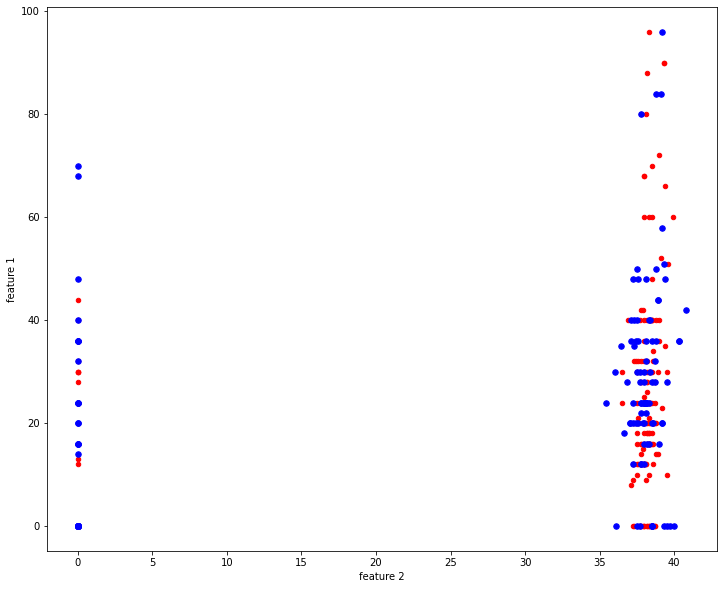

In [3]:
def plt_data(features, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = features[:, 2]
    y = features[:, 4]
    ax.scatter(x[np.where(labels==1)], y[np.where(labels==1)], c='r', s=20)
    ax.scatter(x[np.where(labels==0)], y[np.where(labels==0)], c='b', s=30)
    ax.set_xlabel('feature 2')
    ax.set_ylabel('feature 1')  
plt_data(features, labels)

### 训练算法: 梯度下降算法, 找到最佳系数

In [8]:
def sigmoid_single(inx):
    # sigmod阶跃函数, inx输入为单个数字
    if inx >= 0:  # 防止 inx为负数时出现极大数字
        return 1 / (1 + np.exp(-inx))
    else:
        return np.exp(inx) / (1 + np.exp(inx))

In [9]:
def classify(input_feat, weights):
    # h = sigmoid(np.dot(input_feat, weights))  # (m,)
#     h_list = []
#     for z in np.nditer(np.dot(input_feat, weights)):
#         h_list.append(sigmoid_single(z))
    h_list = list(map(sigmoid_single, np.dot(input_feat, weights)))
    h = np.array(h_list)
    result = np.where(h>0.5, 1, 0)
    return result

In [10]:
def stoc_grad_descent(data_mat, class_labels, iter_num=150):
    """
    再改进:
    1. alpha 在每次迭代的时候都会调整
    2. 随机选取样本拉来更新回归系数 减少周期性的波动
    只返回最终结果
    """
    m, n = data_mat.shape
    weights = np.ones(n)
    for j in range(iter_num):  # 在整个数据集上运行x次
        data_index = list(range(m))  # 0, 1, ...m-1 整个训练样本序号集合
        for i in range(m):
            # i和j的不断增大，导致alpha的值不断减少，但是不为0
            alpha = 4/(1+j+i) + 0.001
            # 随机从训练样本中抽取数据 进行Cost梯度下降,
            # 之后将这个数据从序号集合中删除
            rand_index = int(np.random.uniform(0, len(data_index)))
            # 一个样本的预测值
            h = sigmoid_single(np.sum(data_mat[data_index[rand_index]]*weights))
            error =  h - class_labels[data_index[rand_index]]
            weights -= alpha * error * data_mat[data_index[rand_index]]
            del(data_index[rand_index])
    return weights

In [11]:
def plt_weights_all(weights):
    feature_num, iter_num = weights.shape
    x = np.arange(iter_num)
    f, axes = plt.subplots(feature_num // 4 +1, 4, sharex=True)  #  x行 4列
    for i in range(feature_num):
        y = weights[i]
        a_x, a_y = divmod(i, 4)
        axes[a_x, a_y].plot(x, y)
        axes[a_x, a_y].set_ylabel(f'weight[{i}]')
    plt.xlabel('iteration')

In [12]:
def test_coilr():
    train_features, train_labels = load_data('HorseColicTraining.txt')
    test_features, test_labels = load_data('HorseColicTest.txt')
    weights = stoc_grad_descent(train_features, train_labels)
    result = classify(test_features, weights)  # m*n (n,)
    test_labels = test_labels.astype(int)  # (m,) 
    errors = test_labels ^ result  # 异或, 判断错误的为1
    print(f"错误率:{errors.sum()/errors.shape[0]:.2%}")
%time test_coilr()

错误率:52.24%
CPU times: user 731 ms, sys: 3.49 ms, total: 734 ms
Wall time: 737 ms


## numpy矩阵计算 vs 普通数据相乘

In [13]:
a1 = np.arange(299*21).reshape(299, 21)
a2 = np.arange(299).reshape(299, 1)
w = np.arange(21).reshape(21, 1)
def func0():
    for _ in range(500):
        np.dot(a1, w)
        np.dot(a1.T, a2)  # 
%time func0()

CPU times: user 9.23 ms, sys: 0 ns, total: 9.23 ms
Wall time: 10.9 ms


In [14]:
w = np.arange(21)
def func1():
    for _ in range(200): 
        for j in range(299): 
            np.sum(a1[j]*w)
            np.sum(a2[j] * a1[j])
%time func1()

CPU times: user 571 ms, sys: 4.26 ms, total: 576 ms
Wall time: 582 ms


## 学习率 learning rate
### 学习率大小


||学习率 大|学习率小|  
|:----:|:----:|:----:|
|学习速度|快|慢|
|使用时间点|	刚开始训练时|	一定轮数过后|
|副作用|1.易损失值爆炸；2.易振荡。|1.易过拟合；2.收敛速度慢。|

### 学习率的设置
在训练过程中,一般根据训练轮数设置动态变化的学习率
- 刚开始训练时：学习率以 0.01 ~ 0.001 为宜。
- 一定轮数过后：逐渐减缓。
- 接近训练结束：学习速率的衰减应该在100倍以上。

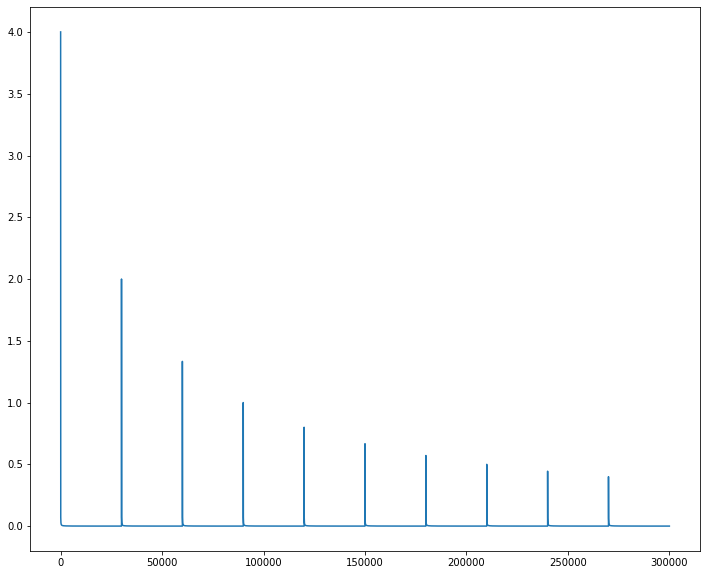

In [23]:
alpha_list = []
for j in range(10):
    for i in range(29999):  # 迭代次数 << 训练样本数量 
        alpha = 4/(i+j+1)+0.001
        alpha_list.append(alpha)
# y = np.array(alpha_list)
# x = np.arange(y.shape[0])
fig = plt.figure()
plt.plot(alpha_list)

In [30]:
alpha_list[:5]


[4.001, 2.001, 1.3343333333333331, 1.001, 0.801]

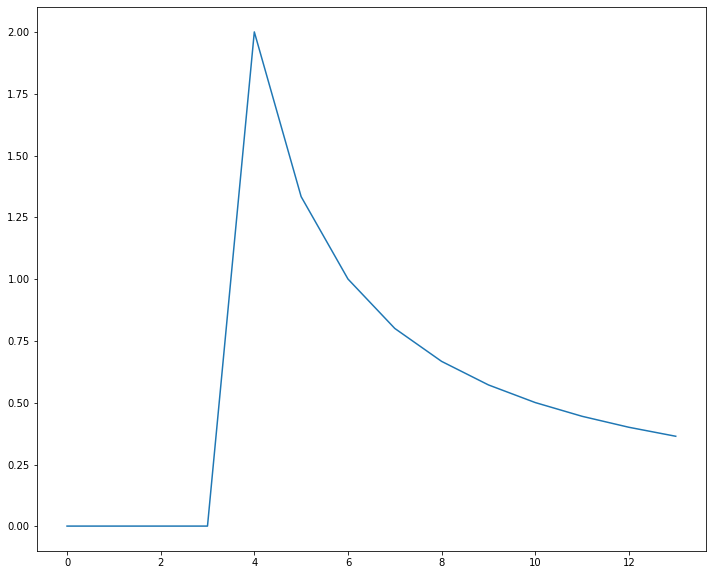

In [34]:
plt.plot(alpha_list[29995:29999+10])

In [12]:
pd.options.display.max_rows = PREVIOUS_MAX_ROWS